In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import sys
sys.path.append('..')

from lib.ChurnEnsemble import ChurnEnsemble

SEED = 42
np.random.seed(SEED)

2024-06-30 20:18:46.755555: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
data = pd.read_csv('../files/churn-data-predict.csv')

data

,cid,id,tp,tfs,tte,ts,te,employees,mrr,value,...,usage_avg,usage_groups_avg,usage_payments_avg,paid_periods,failed_periods,active_periods,momentum,months,failed_ratio,usage_diff
0,51b46d18c4de615d0f000019,1,2017-07-01,4.0,-1.0,2017-03-01,NaN,1,26.58,159.50,...,2.00,0.0,0.0,0.0,0.0,1.0,0.00,4.0,NaN,0.00
1,51b46d18c4de615d0f000019,1,2017-08-01,5.0,-1.0,2017-03-01,NaN,1,26.58,159.50,...,2.00,0.0,0.0,0.0,0.0,2.0,1.20,5.0,NaN,0.00
2,51b46d18c4de615d0f000019,1,2017-09-01,6.0,-1.0,2017-03-01,NaN,1,26.58,239.25,...,2.00,0.0,0.0,1.0,0.0,3.0,-3.14,6.0,0.0,0.00
3,51b46d18c4de615d0f000019,1,2017-10-01,7.0,-1.0,2017-03-01,NaN,1,26.58,239.25,...,1.75,0.0,0.0,1.0,0.0,3.0,-13.60,7.0,0.0,-0.75
4,51b46d18c4de615d0f000019,1,2017-11-01,8.0,-1.0,2017-03-01,NaN,1,26.58,239.25,...,1.60,0.0,0.0,1.0,0.0,3.0,-18.57,8.0,0.0,-0.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,66633bcee489710bb6afe3d9,2680,2024-06-01,0.0,-1.0,2024-06-01,NaN,1,101.97,101.97,...,0.00,0.0,0.0,1.0,0.0,0.0,0.00,0.0,0.0,0.00
101762,666346aee489710bb6afead3,2681,2024-06-01,0.0,-1.0,2024-06-01,NaN,1,40.00,40.00,...,0.00,0.0,0.0,1.0,0.0,0.0,0.00,0.0,0.0,0.00
101763,66634aea1e0bd65a73bf4f2f,2682,2024-06-01,0.0,-1.0,2024-06-01,NaN,1,46.62,46.62,...,0.00,0.0,0.0,1.0,0.0,0.0,0.00,0.0,0.0,0.00
101764,666388b3e489710bb6b00925,2683,2024-06-01,0.0,-1.0,2024-06-01,NaN,1,60.19,60.19,...,0.00,0.0,0.0,1.0,0.0,0.0,0.00,0.0,0.0,0.00


In [3]:
# Load Ensemble model
model = ChurnEnsemble(
    seed=SEED,
    verbose=1,
    path='../files/ensemble'
).set_data(
    data
).load()

model.get_params()

Total Customers: 2.684 | Censored: 2.678 | Non-censored: 6 | Censored Rate 99,78%


{'wtte': {'nn': 24,
  'hl': 2,
  'lr': 0.0001,
  'epochs': 200,
  'batch': 512,
  'lr_decay': 0,
  'stop': 0,
  'dropout': 0.1,
  'weight_l1': 0,
  'weight_l2': 1e-05,
  'init_alpha': None,
  'max_beta': 2.0,
  'shuffle': False,
  'epsilon': 1e-08},
 'xgb': {'n': 200,
  'lr': 0.01,
  'max_depth': 16,
  'stop': 0,
  'metric': 'auc',
  'min_child_weight': 1,
  'gamma': 0,
  'weight_l1': 0,
  'weight_l2': 1,
  'dropout': 0.2,
  'shuffle': False,
  'reg_unb': True}}

In [4]:
# Predict
model.predict()

model.results

1724/1724 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step


,id,tfs,pred,tgt,segment,wa,wb,momentum,cid
0,1,4,0.129388,0,3,26.124920,1.504130,0.00,51b46d18c4de615d0f000019
1,1,5,0.122235,0,3,27.314075,1.631082,1.20,51b46d18c4de615d0f000019
2,1,6,0.114465,0,3,27.145658,1.670454,-3.14,51b46d18c4de615d0f000019
3,1,7,0.353040,1,4,21.365091,1.405037,-13.60,51b46d18c4de615d0f000019
4,1,8,0.330994,1,4,16.299444,1.139788,-18.57,51b46d18c4de615d0f000019
...,...,...,...,...,...,...,...,...,...
101761,2680,0,0.645647,1,5,7.914795,0.985071,0.00,66633bcee489710bb6afe3d9
101762,2681,0,0.608571,1,5,9.876586,0.927684,0.00,666346aee489710bb6afead3
101763,2682,0,0.717192,1,5,7.052105,0.967757,0.00,66634aea1e0bd65a73bf4f2f
101764,2683,0,0.624678,1,5,8.658666,1.006293,0.00,666388b3e489710bb6b00925


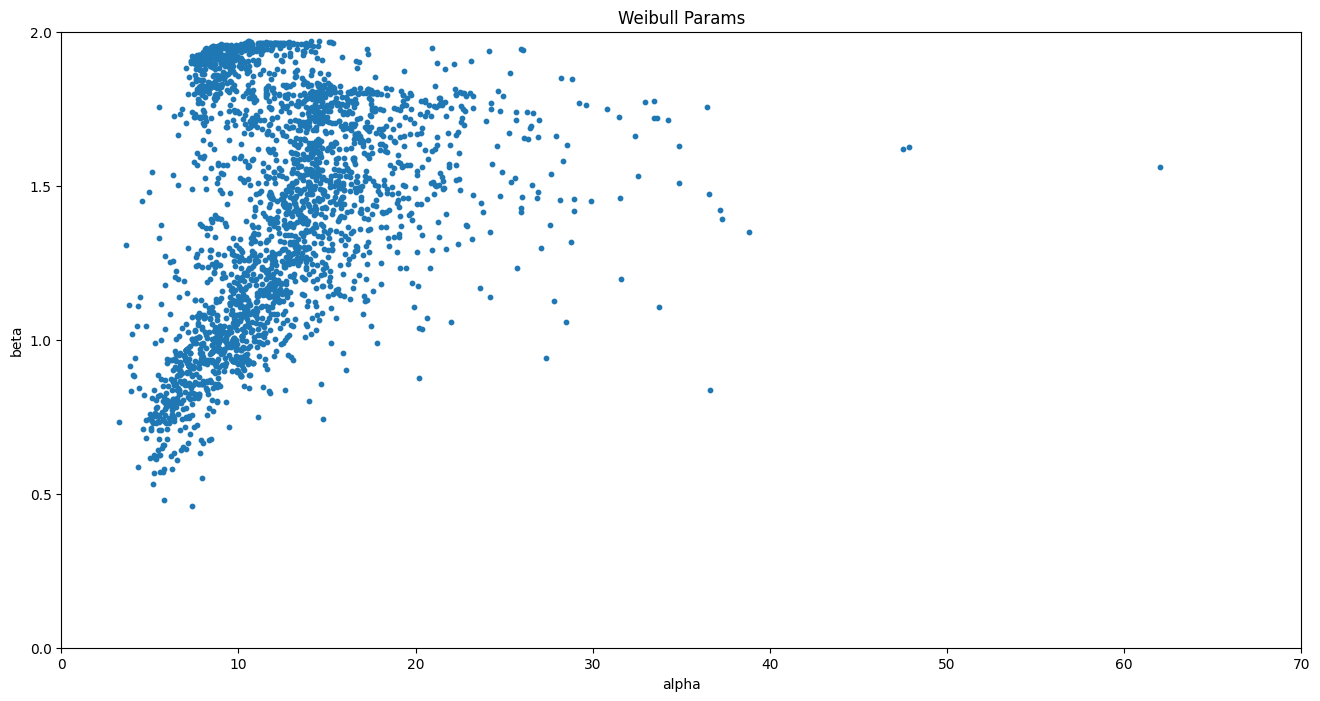

In [5]:
# Plot parameters distribution
model.wtte.plot_params_dist(model.wtte.results, loc=-1)

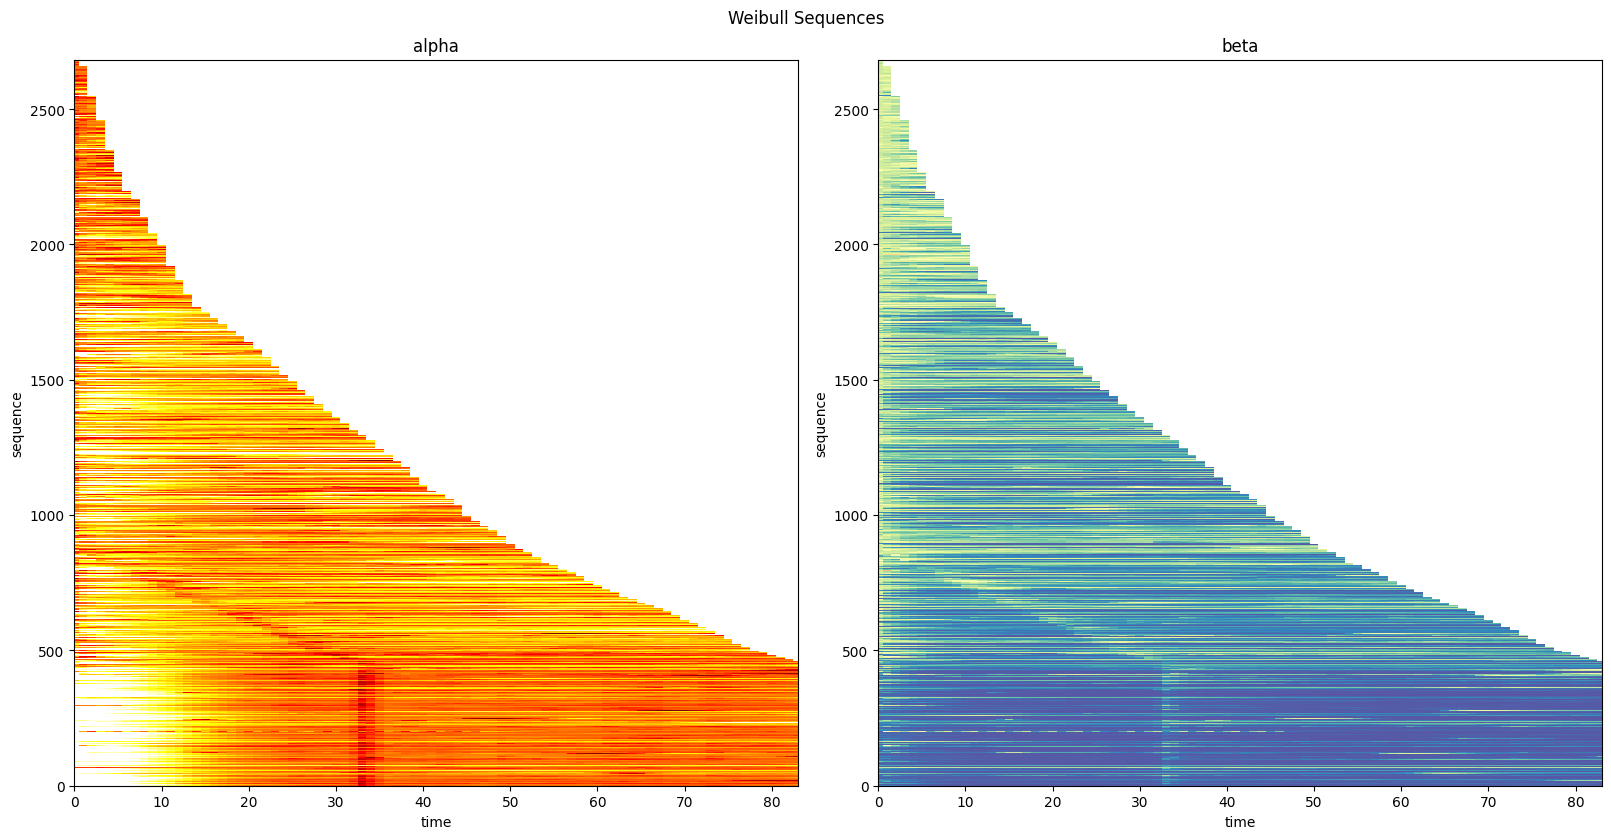

In [6]:
# Plot each customer Weibull alpha and beta parameters over time
model.wtte.plot_params_seq(model.wtte.results)

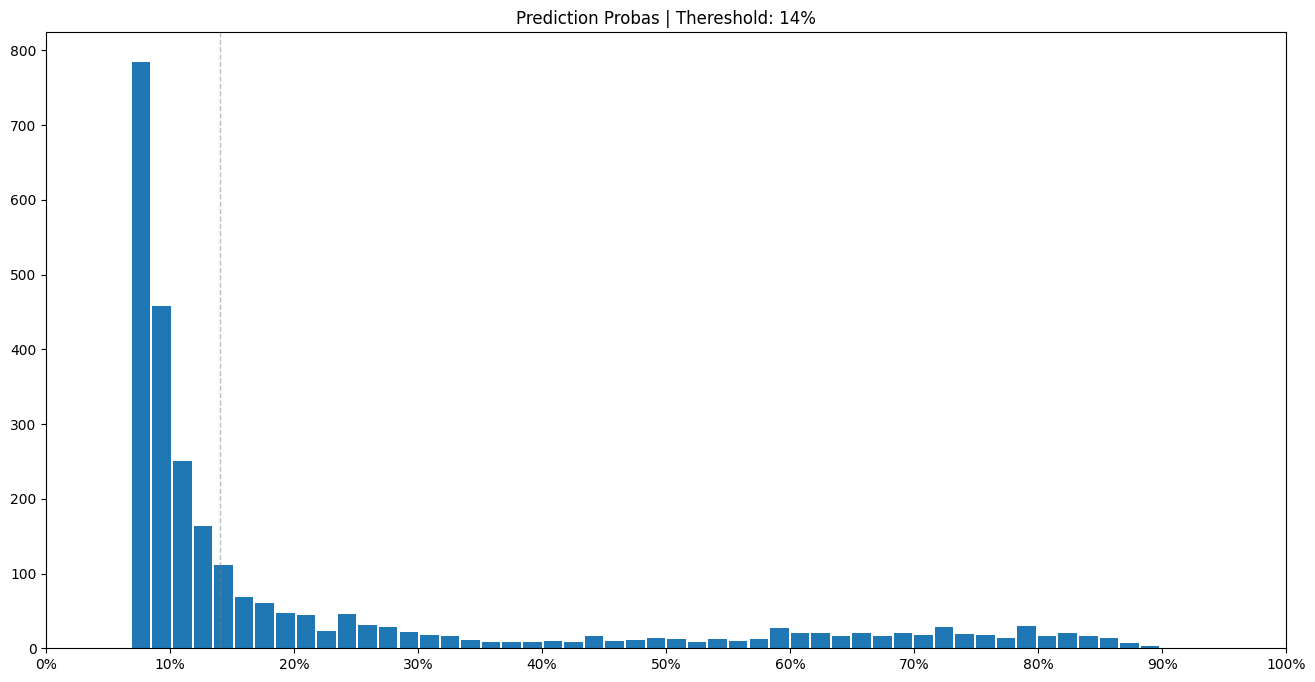

In [7]:
# Plot histogram of predicted probabilities for each customer sequence
model.plot_histogram()

In [8]:
# Get the predictions DataFrame.
df = model.get_predictions(loc=-1)

df

,id,pred,tgt,segment,wa,wb,momentum,cid
83,1,0.211864,1,4,5.630028,1.114587,-22.60,51b46d18c4de615d0f000019
167,2,0.072842,0,1,9.484993,1.884397,1.80,51c6bee4885ef11f7200030b
251,3,0.078424,0,1,9.445155,1.804380,1.07,51d4af244e30af6436000001
335,4,0.070887,0,1,10.098000,1.907301,0.23,51de98a50f42e6597c00009c
419,5,0.068908,0,1,10.744211,1.954768,0.23,51e7ebf61aae11927e00001e
...,...,...,...,...,...,...,...,...
101761,2680,0.645647,1,5,7.914795,0.985071,0.00,66633bcee489710bb6afe3d9
101762,2681,0.608571,1,5,9.876586,0.927684,0.00,666346aee489710bb6afead3
101763,2682,0.717192,1,5,7.052105,0.967757,0.00,66634aea1e0bd65a73bf4f2f
101764,2683,0.624678,1,5,8.658666,1.006293,0.00,666388b3e489710bb6b00925
